In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandarallel import pandarallel
from sklearn.feature_extraction.text import TfidfVectorizer
from features import HTMLFeatures, URLFeatures
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# **PHISHING DATASET ANALYSIS**

* * *

In [2]:
# importing datasets
texts = pd.read_csv('DATASETS/PRE/TEXTS.csv')
urls = pd.read_csv('DATASETS/PRE/URLS.csv')
webs = pd.read_csv('DATASETS/PRE/WEBS.csv')

### Classes Distribution

In [3]:
dist = pd.concat([texts['label'], urls['label'], webs['label']]).value_counts()
dist.index = dist.index.map({0: 'Benigno', 1: 'Phishing'})
plt.text(230010, 0, '53.5%', color='black', fontweight='bold')
plt.text(200000, 1, '46.5%', color='black', fontweight='bold')
dist.plot.barh(color=['royalblue', 'gold'])

<Axes: ylabel='label'>

## **URL Analysis**

A URL has lexical characteristics, which refer to the textual properties of the URL. According to some investigations, some URL features related to phishing attacks are:

- Presence of suffix or prefix "-" in the domain
- Points number
- Presence of the IP direction in the domain
- Presence of keywords such as 'login', 'server', and 'admin'
- Subdirectories number
- Host Length
- etc

In [4]:
# extract url relevant features
urls = pd.DataFrame([URLFeatures(row.text).get_features()|{'label': row.label} for row in urls.itertuples(index=False)])
urls = urls.astype(int)

In [5]:
# calculate averages of each feature by class
urls_features = pd.concat([
    urls.loc[urls['label'] == 0].mean(axis=0),
    urls.loc[urls['label'] == 1].mean(axis=0)
], axis=1).rename(columns={0: 'Benigno', 1:'Phishing'})[:-1]

In [6]:
# calculate proportions in bool url features
url_proportions = urls_features.copy()[:11] * 100
url_proportions['Diff'] = abs(url_proportions['Benigno'] - url_proportions['Phishing']).round(3)
url_proportions

Benigno   Phishing    Diff
use_shortening_service  7.072162   5.166026   1.906
prefix_suffix_presence  0.626812  11.062183  10.435
has_double_slash        0.018980   0.631297   0.612
has_haveat_sign         0.056713   1.186786   1.130
has_port                0.017151   0.026390   0.009
has_admin_keyword       0.101534   1.906051   1.805
has_server_keyword      0.216560   0.485892   0.269
has_login_keyword       0.192320   9.076185   8.884
has_client_keyword      0.102677   0.527547   0.425
host_is_ip              0.000229   0.561181   0.561
is_encoded              2.544524   1.558320   0.986

In [7]:
# calculate averages in numeric url features
url_averages = urls_features.copy()[11:]
url_averages['Pct Change'] = ((url_averages[['Benigno', 'Phishing']].pct_change(axis=1)['Phishing']) * 100).round(3)
url_averages

Benigno   Phishing  Pct Change
length              47.004192  47.575145       1.215
path_length         41.423458  25.190401     -39.188
host_length          1.815871   9.813579     440.434
entropy              3.641731   3.502396      -3.826
digits_num           3.065922   5.017011      63.638
subdirectories_num   3.320061   2.533673     -23.686
periods_num          1.825842   2.467589      35.148
params_num           0.183683   0.259251      41.141

## **HTML ANALYSIS**

From websites we can also extract characteristics concerning to phishing. These features capture the structure of the web page and the content included in it, such as:

- Number of internal & external links
- Number of functions that modify the DOM
- Number of scripts
- Number of tags
- Number of suspicious scripts functions
- etc

In [8]:
# extract html relevant features
webs = pd.DataFrame([HTMLFeatures(row.text).get_features()|{'label': row.label} for row in webs.itertuples(index=False)])
webs = webs.astype(int)

In [10]:
# calculate averages of each feature by class
webs_features = pd.concat([
    webs.loc[webs['label'] == 0].mean(axis=0),
    webs.loc[webs['label'] == 1].mean(axis=0)
], axis=1).rename(columns={0: 'Benigno', 1:'Phishing'})[:-1]

# Calculate differences between phishing and benign features in percentage
webs_features['Pct Change'] = ((webs_features[['Benigno', 'Phishing']].pct_change(axis=1)['Phishing']) * 100).round(3)

webs_features

Benigno     Phishing  Pct Change
suspicious_func_num          0.312549     0.274035     -12.322
page_entropy                 4.478566     4.316642      -3.616
script_tags_num             15.126072     6.244720     -58.716
html_length              14183.575799  7956.913693     -43.901
tokens_num                1157.061185   550.026038     -52.464
sentences_num              236.187744   159.838128     -32.326
punctuation_num           2224.979345  1394.538602     -37.324
capitalization_num        1352.086321   976.650947     -27.767
avg_sentence_tokens_num      8.169817     9.974873      22.094
html_tags_num              361.285269   129.689913     -64.103
hidden_tags_num              0.298032     0.226329     -24.059
iframe_num                   0.410951     0.189366     -53.920
objects_num                  0.016758     0.007465     -55.451
embeds_num                   0.004579     0.004552      -0.590
internal_links_num          26.731294     1.229425     -95.401
external_links_num          27.560503     6.596140     -76.067
whitespaces_num           2460.243277  1703.753642     -30.749
included_elements_num        8.317128     3.753277     -54.873
double_doc_num               0.000000     0.000000         NaN
keywords_to_words_ratio      0.000000     0.000000         NaN
dom_mod_func_num             7.210542     4.048070     -43.859
avg_script_len             549.005553   878.392025      59.997
avg_script_entropy           1.740939     1.603423      -7.899

In [11]:
# Filtrate features with a significant difference (>50%)
relevant_webs_features = webs_features.loc[webs_features['Pct Change'].abs() > 50]
relevant_webs_features

Benigno    Phishing  Pct Change
script_tags_num          15.126072    6.244720     -58.716
tokens_num             1157.061185  550.026038     -52.464
html_tags_num           361.285269  129.689913     -64.103
iframe_num                0.410951    0.189366     -53.920
objects_num               0.016758    0.007465     -55.451
internal_links_num       26.731294    1.229425     -95.401
external_links_num       27.560503    6.596140     -76.067
included_elements_num     8.317128    3.753277     -54.873
avg_script_len          549.005553  878.392025      59.997

In [12]:
# plot features gain averages by class
relevant_webs_features[['Benigno', 'Phishing']].plot.bar(width=0.4, figsize=(10, 5), color=['royalblue', 'gold'])
plt.xlabel('Características')
plt.ylabel('Promedio Logarítmico')
plt.title('PROMEDIO DE LAS CARACTERÍSTICAS HTML POR CLASE')
plt.yscale('log')
plt.xticks(rotation=30)
plt.show() 

## **TEXT ANALYSIS**

Text preprocessing is a fundamental step in textual data analysis, which consists of cleaning and transforming unstructured text to prepare it for natural language processing (NLP) tasks. Some of the most common text preprocessing techniques are:

- Converting text to lowercase
- Removing punctuation marks
- Removing stop words
- Removing very frequent or very rare words
- Applying stemming or lemmatization of words

In [12]:
%load_ext Cython

In [13]:
%%cython
import re
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text: str):
    """Preprocess text with regex and NLTK library"""
    text = re.sub(r'[^\w\s]', ' ', text) # remove punctuation signs and special chars
    text = re.sub(r' +', ' ', text) # remove unnecessary spaces
    text = text.lower() # put text in lower case
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(text)])
    return text.strip()

In [14]:
texts['text'] = texts['text'].parallel_map(preprocess_text)
texts

text  label
0      6 1100 disc uniformitarianism 1086 sex lang di...      0
1      side galicismos galicismo spanish term name im...      0
2      equistar deal ticket still available assist ro...      0
3      hello hot lil horny toy one dream open mind pe...      1
4      software incredibly low price 86 low drapery s...      1
...                                                  ...    ...
20132  nokia 7250i get win free auction take part sen...      1
20133  get ur 1st ringtone free reply msg tone gr8 to...      1
20134  ur cash balance currently 500 pound maximize u...      1
20135  record indicate involve accident last 2 5 year...      1
20136  call 08707509020 20p per min ntt ltd po box 13...      1

[20137 rows x 2 columns]

### TF-IDF Analysis

TF-IDF Vectorizer is a very common algorithm to transform text into a meaningful representation of numbers, which can be used for our text analysis. 

In [15]:
# vectorize texts
vect = TfidfVectorizer(ngram_range=(1, 2), max_df=0.25, stop_words='english')
vect_matrix = vect.fit_transform(texts['text'])

**TF-IDF (term frequency-inverse document frequency)** is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents. The higher is the value, the more relevant the term is in that document. Hence, we'll check TF-IDF averages scores of all features extracted from TF-IDF Vectorizer and sort them in descending order, so we can know which are the most relevant words over all texts corpus.

In [16]:
# Get TF-IDF scores from all features
tfidfs = pd.DataFrame.sparse.from_spmatrix(vect_matrix, columns=vect.get_feature_names_out())

In [17]:
# Calculate TF-IDF Averages and sort them in descending order
tfidf_avgs = tfidfs.mean(axis=0).sort_values(ascending=False)[:20]
tfidf_avgs

list           0.010181
enron          0.010109
ect            0.008954
www            0.007807
mail           0.007708
linux          0.006962
http www       0.006893
email          0.006833
use            0.006571
free           0.006371
net            0.006361
time           0.006289
make           0.006224
new            0.006212
click          0.006084
message        0.006071
00             0.006008
language       0.005969
information    0.005788
know           0.005758
dtype: Sparse[float64, 0]

In [18]:
plt.barh(tfidf_avgs.index, tfidf_avgs.values, color='limegreen')
plt.xlabel("Promedio TF-IDF")
plt.ylabel("Palabra")
plt.title('TOP 2O PALABRAS MÁS RELEVANTES')
plt.show()

**IDF** is a measure of how common or rare a term is across the entire corpus of documents (texts samples). If the word is common and appears in many documents, the idf value (normalized) will approach 0 or else approach 1 if it’s rare. Hence, let's see which are the most common words across all texts samples using this measure.

In [19]:
feature_names = vect.get_feature_names_out()

In [20]:
idfs = vect.idf_ * (1/vect.idf_.max()) # normalize idfs vector between 0 to 1
lower_idfs_indexes = np.argsort(idfs)[:20]
most_common_words = [feature_names[i] for i in lower_idfs_indexes]
most_common_words_idfs = [idfs[i] for i in lower_idfs_indexes]

In [21]:
pd.Series(data=most_common_words_idfs, index=most_common_words)

mail           0.240285
time           0.242369
www            0.243095
use            0.243417
list           0.248152
make           0.249883
information    0.251177
new            0.251621
know           0.256461
http www       0.256707
like           0.257499
work           0.259227
email          0.261943
need           0.262360
subject        0.265112
message        0.268192
10             0.270603
want           0.283349
day            0.284389
include        0.284749
dtype: float64

In [22]:
plt.barh(most_common_words, most_common_words_idfs, color='limegreen')
plt.xlabel("IDF")
plt.ylabel("Palabra")
plt.title('TOP 20 PALABRAS MÁS COMUNES')
plt.show()

In [23]:
benign_tf = pd.Series(' '.join(texts[texts['label'] == 0].text).split()).value_counts()
benign_tf = benign_tf[benign_tf.index.isin(tfidf_avgs.index.values)]
benign_tf.name = 'Benigno'

phishing_tf = pd.Series(' '.join(texts[texts['label'] == 1].text).split()).value_counts()
phishing_tf = phishing_tf[phishing_tf.index.isin(tfidf_avgs.index.values)]
phishing_tf.name = 'Phishing'

In [24]:
tf = pd.concat([benign_tf, phishing_tf], axis=1)
tf

Benigno  Phishing
language       23700        93
enron          17840         3
mail           13206      5376
use            12264      2937
list           11119      3270
ect            10902        76
information    10816      3720
00             10772      3279
www            10486      3069
new            10277      3068
make            9586      4719
time            8505      3614
email           6787      5496
know            6522      1759
message         5598      1816
net             5419      1921
free            3899      4526
linux           3795       411
click           1659      2969

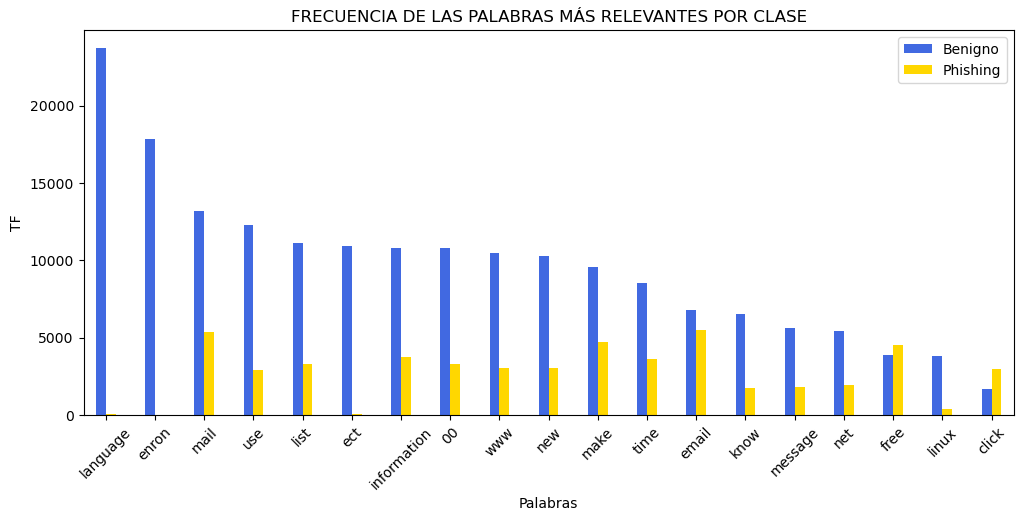

In [27]:
# plot features gain averages by class
tf[['Benigno', 'Phishing']].plot.bar(width=0.4, figsize=(12, 5), color=['royalblue', 'gold'])
plt.xlabel('Palabras')
plt.ylabel('TF')
plt.title('FRECUENCIA DE LAS PALABRAS MÁS RELEVANTES POR CLASE')
plt.xticks(rotation=45)
plt.show() 